<h1>Computing Sea Surface Elevation Estimates</h1>
Written By: EJ Rainville, Spring 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
import cftime
import netCDF4 as nc
import xarray as xr
import glob
import datetime
from matplotlib.animation import FuncAnimation
from IPython import display
%matplotlib widget

In [2]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

Let's start first by choosing a test data set. This dataset will be Mission 30 from the main DUNEX experiment. This dataset was chosen since it was near the 4.5 m AWAC for a very long time and we will use that to compare the spectra from the AWAC and the microSWIFT to see how well the microSWIFT is statistically able to produce the same spectra.



In [3]:
# Load Mission 30 dataset and look at microSWIFT 12
mission_dataset = nc.Dataset('../microSWIFT_data/cleanedDataset/mission_30.nc')
microSWIFT_test = microSWIFT(mission_dataset, microSWIFT_num='microSWIFT_12')
print('Start of this Mission: {}'.format(microSWIFT_test.time_datetime[0]))

Start of this Mission: 2021-10-13 14:18:00


In [4]:
# Data from 4.5 meter AWAC
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
time_index = 302
f_awac = awac_data['waveFrequency'][:]
E_awac = awac_data['waveEnergyDensity'][time_index,:]
xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))
print('Time of Spectra: {}'.format(cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)[time_index]))
print('4.5 m AWAC: Hs = {0:.2f} meters'.format(awac_data['waveHs'][time_index]))
print('4.5 m AWAC: Tp = {0:.2f} seconds'.format(awac_data['waveTp'][time_index]))

Time of Spectra: 2021-10-13 14:00:06
4.5 m AWAC: Hs = 1.27 meters
4.5 m AWAC: Tp = 5.91 seconds


Now that we have the microSWIFT data and the AWAC data that we are interested in examining, lets see how close the microSWIFT actually was to the AWAC during this deployment.

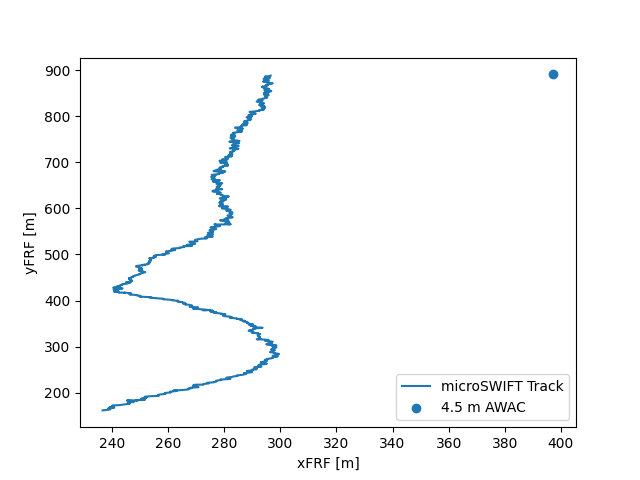

In [5]:
# Plot track of the microSWIFT and the location of the AWAC
fig_location, ax = plt.subplots()
ax.plot(microSWIFT_test.x, microSWIFT_test.y, label='microSWIFT Track')
ax.scatter(xFRF_awac, yFRF_awac, label='4.5 m AWAC')
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')
ax.legend()

Now looking at the track and the location of the AWAC, we will assume that the time when the microSWIFT is between 900 and 700 meters in the yFRF location that it should have a very similar spectra(shoaled from the AWAC) to the AWAC. So the next step is to subset the data to include only that chunk of data for this analysis.

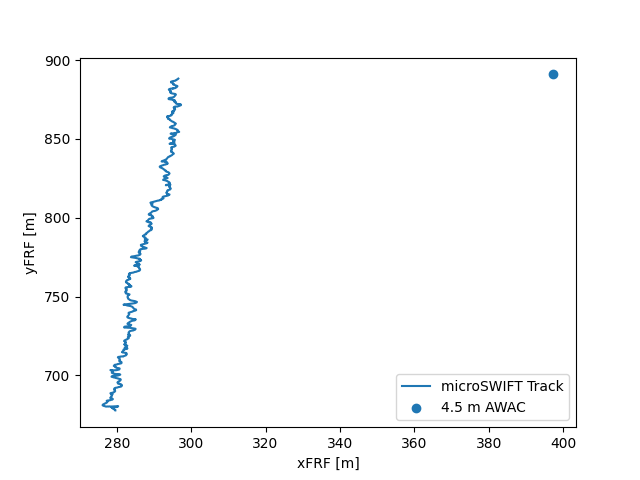

In [6]:
# Subset of data when microSWIFT is between 900 and 700 meters in yFRF coordinates
start_ind = 0
end_ind = 6000
fig_location, ax = plt.subplots()
ax.plot(microSWIFT_test.x[start_ind:end_ind], microSWIFT_test.y[start_ind:end_ind], label='microSWIFT Track')
ax.scatter(xFRF_awac, yFRF_awac, label='4.5 m AWAC')
ax.set_xlabel('xFRF [m]')
ax.set_ylabel('yFRF [m]')
ax.legend()

Now going from index 0 to index 6000 we have a subset of data where the microSWIFT is just in front of the 4.5 meter AWAC. This subset of data has 6000 data points which is aprroximately 500 seconds of data or 8.3 minutes of data. The next step is to look at the energy spectrum from the 4.5 meter AWAC and get a feel for the data that we expect.

Frequency Resolution of AWAC: 0.007500000298023224


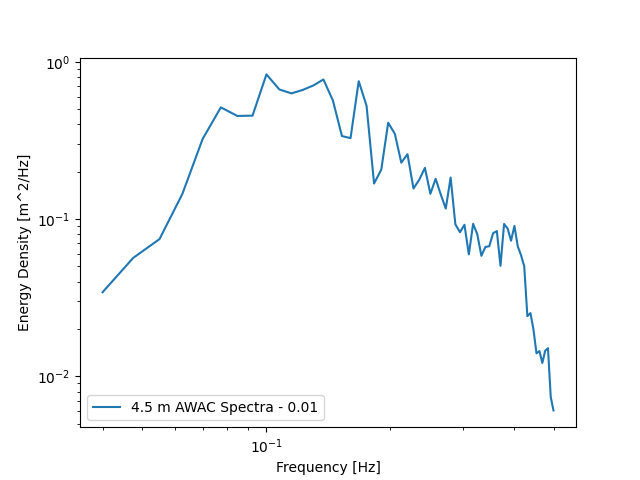

In [59]:
# AWAC Frequnecy resolution 
del_f = f_awac[4] - f_awac[3]
print('Frequency Resolution of AWAC: {}'.format(del_f))

# Plot 4.5 Meter AWAC Spectra 
fig_awac_spec, ax = plt.subplots()
ax.loglog(f_awac, E_awac, label='4.5 m AWAC Spectra - {0:.2f}'.format(del_f))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')
ax.legend()

Now we want to anaylze the acceleration data during the period of interest from the microSWIFT.

<class 'numpy.ndarray'>


Text(0, 0.5, 'Acceleration [m/s^2]')

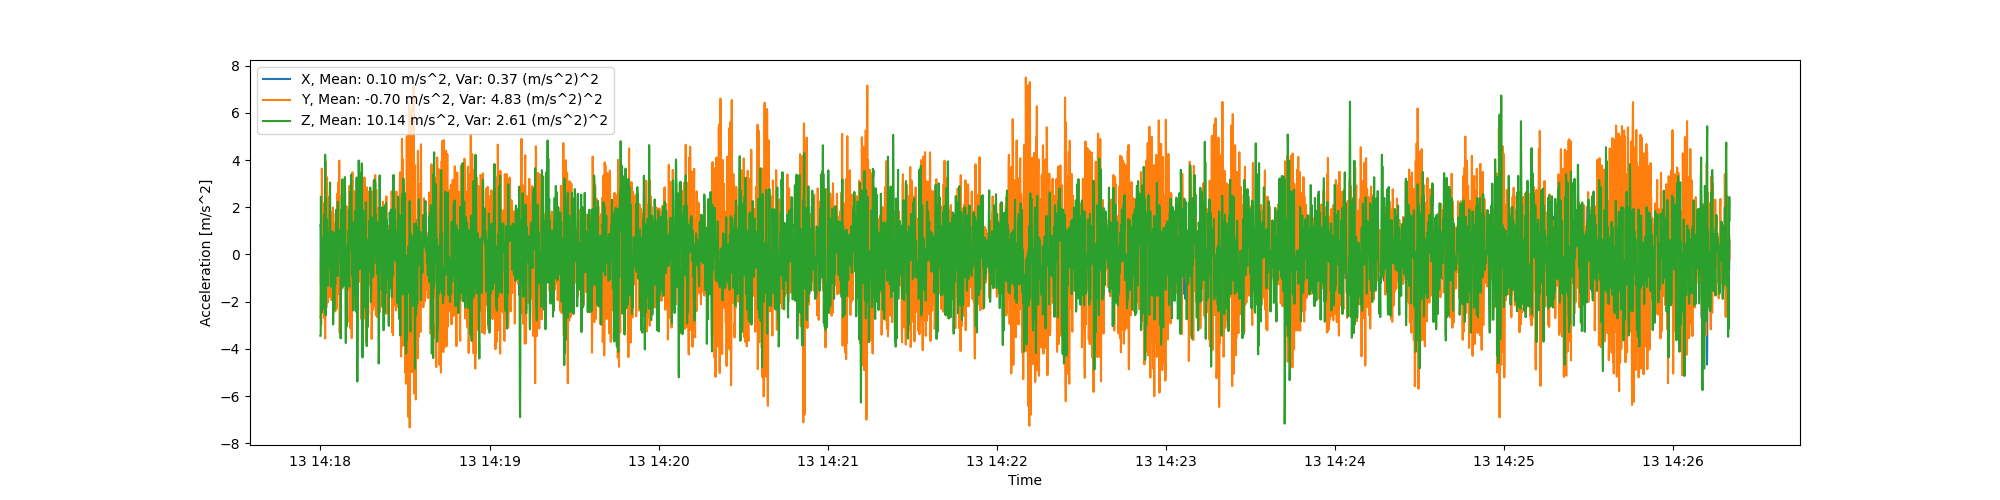

In [8]:
# Define time during the period of interest
time_datetime = microSWIFT_test.time_datetime[start_ind:end_ind]
time = microSWIFT_test.time[start_ind:end_ind]

# Define acceleration variables during the mission
accel_x = np.array(microSWIFT_test.ax_body[start_ind:end_ind])
accel_y = np.array(microSWIFT_test.ay_body[start_ind:end_ind])
accel_z = np.array(microSWIFT_test.az_body[start_ind:end_ind])
print(type(accel_x))
# Compute the Mean value of acceleration 
accel_x_mean = np.mean(accel_x)
accel_y_mean = np.mean(accel_y)
accel_z_mean = np.mean(accel_z)

# Compute Variance of Acceleration
accel_x_var = np.var(accel_x)
accel_y_var = np.var(accel_y)
accel_z_var = np.var(accel_z)

# Remove the Mean from each acceleration
accel_x_demean = accel_x - accel_x_mean
accel_y_demean = accel_y - accel_y_mean
accel_z_demean = accel_z - accel_z_mean

# Plot the Demeaned Accelerations
fig_accel_raw, ax = plt.subplots(figsize=(20,5))
ax.plot(time_datetime, accel_x_demean, label='X, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_x_mean, accel_x_var))
ax.plot(time_datetime, accel_y_demean, label='Y, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_y_mean, accel_y_var))
ax.plot(time_datetime, accel_z_demean, label='Z, Mean: {0:.2f} m/s^2, Var: {1:.2f} (m/s^2)^2'.format(accel_z_mean, accel_z_var))
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2]')


Currently, each signal looks really jumpy so it is hard to tell if there are any really coherent, wave-like structures. Funny enough, it almost looks like the Y acceleration shows more coherent wave structures than Z does which is strange. Lets look at these signals in the Fourier Domain and see whats up.

Text(0, 0.5, 'Amplitude [m/s^2]')

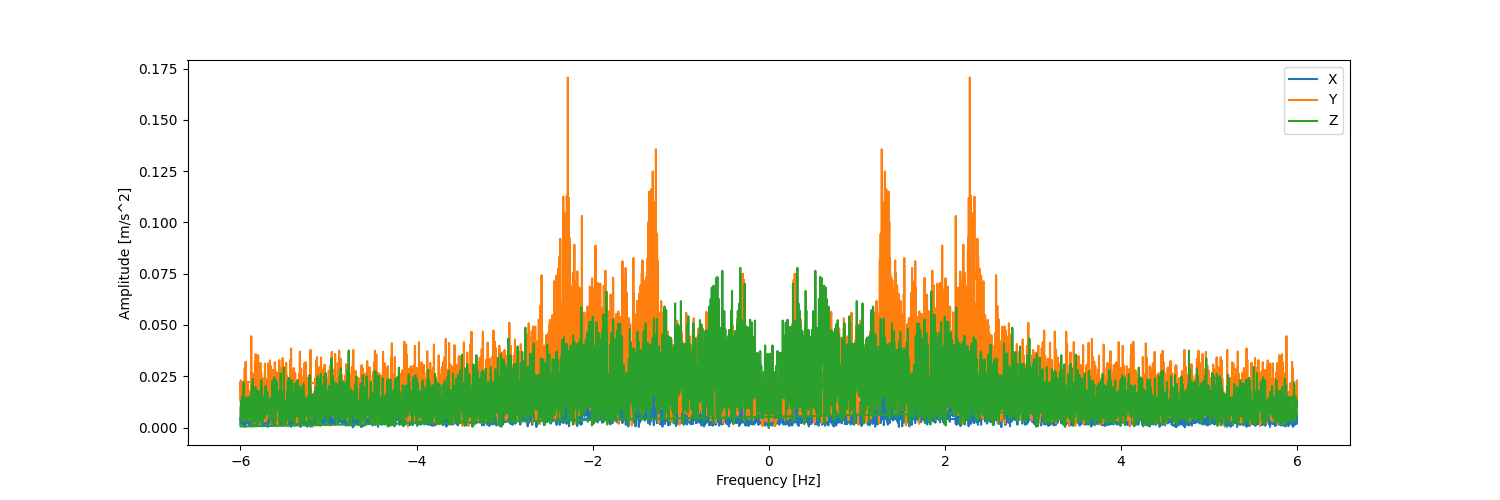

In [9]:
# Compute FFT of each demeaned acceleration signal
sample_freq = np.float64(microSWIFT_test.sampling_freq)
freq = np.fft.fftfreq(accel_x_demean.size, d=1/sample_freq)
#*Note this has been normalized by the number of points 
num_points = freq.size
accel_x_fft = np.fft.fft(accel_x_demean)/num_points
accel_y_fft = np.fft.fft(accel_y_demean)/num_points
accel_z_fft = np.fft.fft(accel_z_demean)/num_points

# Plot the Real Part of the FFT for each acceleration
fig_accel_fft, ax = plt.subplots(figsize=(15,5))
ax.plot(freq, np.abs(accel_x_fft), label='X')
ax.plot(freq, np.abs(accel_y_fft), label='Y')
ax.plot(freq, np.abs(accel_z_fft), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m/s^2]')


Now lets make this a one sided spectrum to analyze closer and integrate it in the Fourier domain.

Text(0, 0.5, 'Amplitude [m/s^2]')

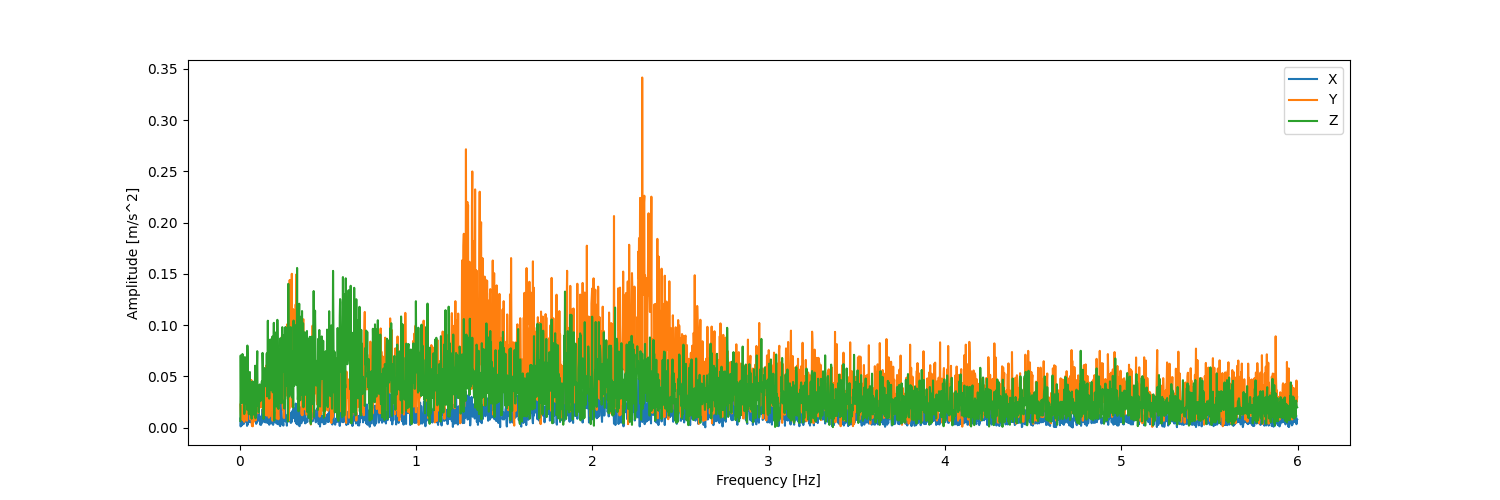

In [10]:
# Find all indices of the frequnecy greater than 0
onesided_ind = freq > 0
freq_onesided = freq[onesided_ind]

# Note that the one sided spectrum must be rescaled by a factor of 2 
accel_x_fft_onesided = accel_x_fft[onesided_ind] * 2
accel_y_fft_onesided = accel_y_fft[onesided_ind] * 2
accel_z_fft_onesided = accel_z_fft[onesided_ind] * 2

# Plot the one sided spectrum to examine it in more detail 
fig_accel_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(accel_x_fft_onesided), label='X')
ax.plot(freq_onesided, np.abs(accel_y_fft_onesided), label='Y')
ax.plot(freq_onesided, np.abs(accel_z_fft_onesided), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m/s^2]')



When we look at this one sided spectrum, we see that the z acceleration is almost not affected at frequencies higher than the wave band while the y acceleration is drastically affected at higher frequencies. This leads me to the thought that potentialyl correcting this could make it worse and maybe just filtering the z acceleration is the way after all. Lets try now to just integrate this signal and see what happens.

Text(0, 0.5, 'Amplitude [m]')

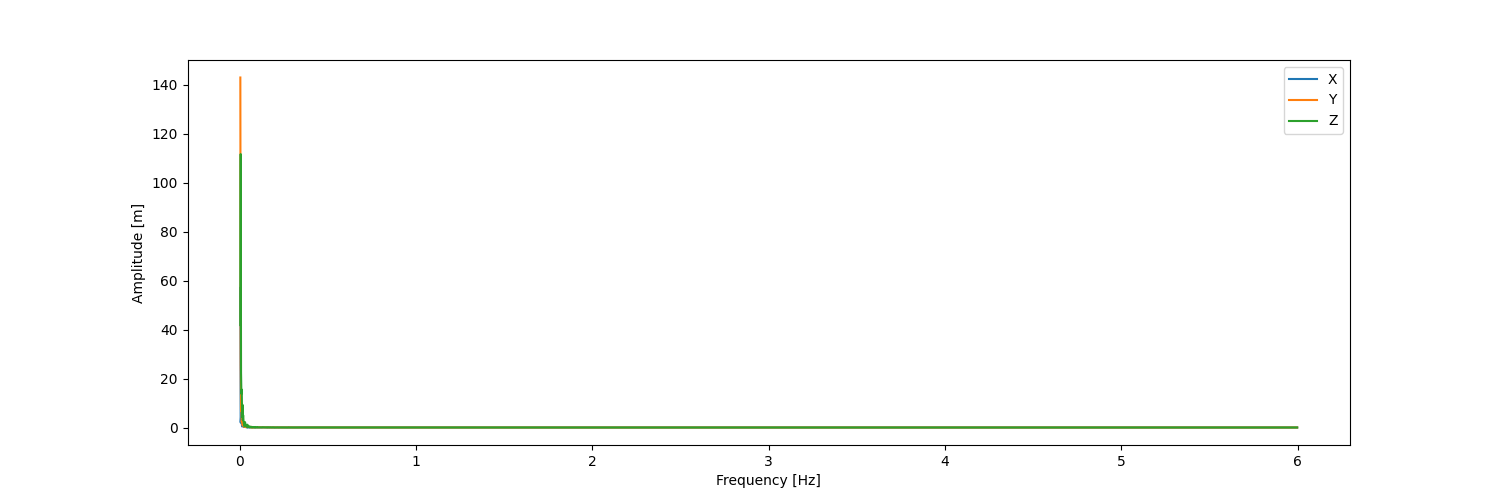

In [11]:
# Define integration array from the frequencies
double_integration_array = -1 / ((2 * np.pi * freq_onesided)**2)

# Now multiply each of the acceleration fft's by this array to get the integrated fourier transform 
x_fft_onesided = double_integration_array * accel_x_fft_onesided
y_fft_onesided = double_integration_array * accel_y_fft_onesided
z_fft_onesided = double_integration_array * accel_z_fft_onesided

# Plot the integrated spectra of position
fig_pos_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(x_fft_onesided), label='X')
ax.plot(freq_onesided, np.abs(y_fft_onesided), label='Y')
ax.plot(freq_onesided, np.abs(z_fft_onesided), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')

Wow this is impressive! The low frequency components sky rocket while the rest of the components are almost zero. This most definetly needs to be fixed with some sort of filter. Lets first try by zeroing out all components of acceleration below 0.045 (just below the wave band) which is where it seems to have the largest explosion due to multiplying by orders or magnitude!

Text(0, 0.5, 'Amplitude [m]')

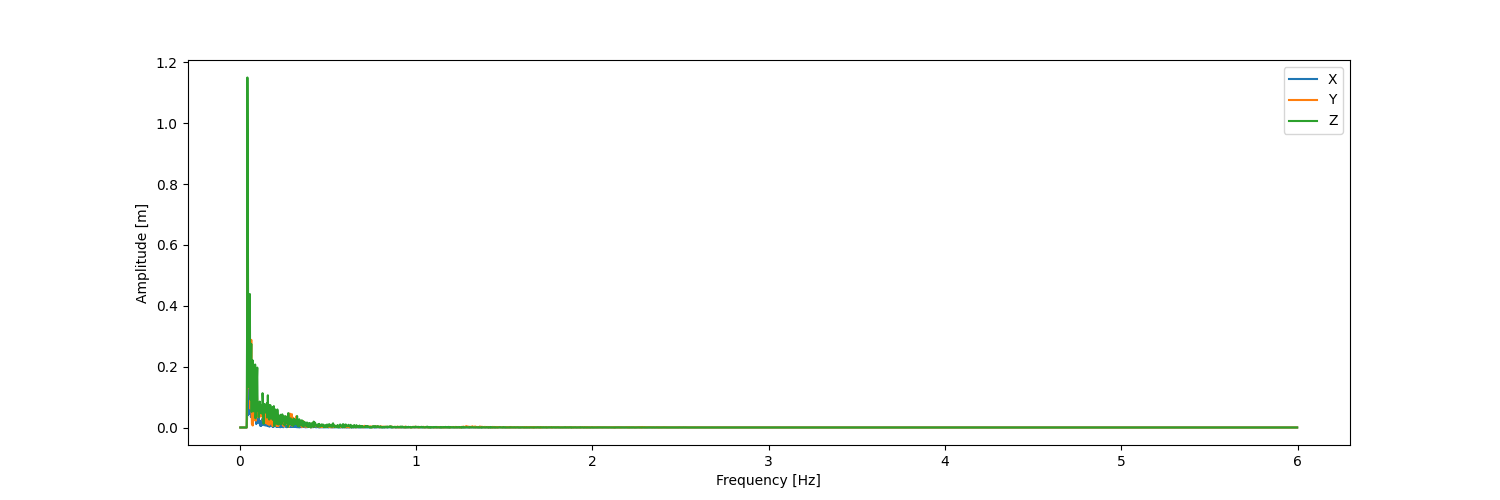

In [12]:
# Find all indices of frequnecy between zero and 0.01
low_freq_ind = freq_onesided < 0.04

# Zero out all low frequency components of acceleration and integrate again 
accel_x_fft_onesided_low_freq_cut = accel_x_fft_onesided.copy()
accel_x_fft_onesided_low_freq_cut[low_freq_ind] = 0
accel_y_fft_onesided_low_freq_cut = accel_y_fft_onesided.copy()
accel_y_fft_onesided_low_freq_cut[low_freq_ind] = 0
accel_z_fft_onesided_low_freq_cut = accel_z_fft_onesided.copy()
accel_z_fft_onesided_low_freq_cut[low_freq_ind] = 0

# Double integrate the Acceleratiosn again and plot to see what happens
x_fft_onesided_low_freq_cut = double_integration_array * accel_x_fft_onesided_low_freq_cut
y_fft_onesided_low_freq_cut = double_integration_array * accel_y_fft_onesided_low_freq_cut
z_fft_onesided_low_freq_cut = double_integration_array * accel_z_fft_onesided_low_freq_cut

# Plot the integrated spectra of position
fig_pos_fft_onesided, ax = plt.subplots(figsize=(15,5))
ax.plot(freq_onesided, np.abs(x_fft_onesided_low_freq_cut), label='X')
ax.plot(freq_onesided, np.abs(y_fft_onesided_low_freq_cut), label='Y')
ax.plot(freq_onesided, np.abs(z_fft_onesided_low_freq_cut), label='Z')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')

Well this looks very good! Frusteratingly, it seems that the peak will most likely end up wherever the filter cut off is due to the nature of integrating those low frequency values. Hmm, what do we do about that? Well anyway for now, lets try computing the energy spectrum now and see how it compares with the spectrum from the 4.5 m AWAC. 

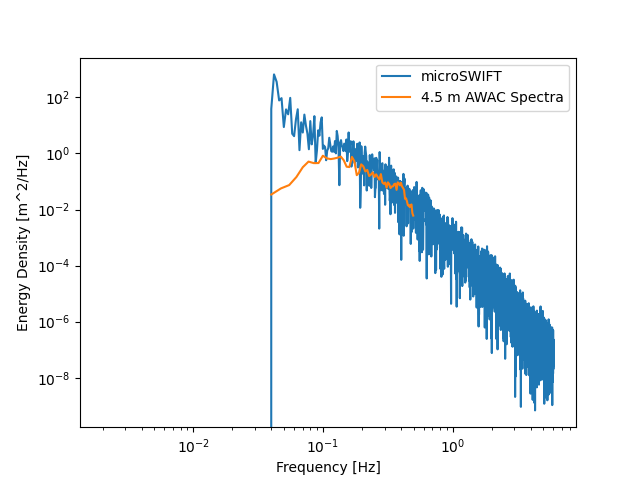

In [13]:
# Compute the Energy Density Spectrum of the position FFT of z which should be spectrum of sea surface elevation
# * Note that it is normalized by the frequency resolution to make a density
del_f = sample_freq / num_points
E_micro = np.abs(z_fft_onesided_low_freq_cut**2) / del_f

# Plot the Energy Spectrum compared to the AWAC spectrum
fig_spec, ax = plt.subplots()
ax.loglog(freq_onesided, E_micro, label='microSWIFT')
ax.loglog(f_awac, E_awac, label='4.5 m AWAC Spectra')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')
ax.legend()


This is very encouraging! We are getting a high frequency tail that is very representative of the energy spectrum from the AWAC with almost no filtering which is really nice! Now what do we do about the low frequency end? We need to develop a filter that will handle this low frequency end and reduce the energy in it. Lets try to solve for an optimized filter design by minimized the mean square error between the AWAC spectrum and the microSWIFT spectrum. Lets first see what the current mean square error is between the two.

In [14]:
# Interpolate the AWAC spectra onto the resolution of the microSWIFT spectra to compare one-to-one
E_awac_micro_res = np.interp(freq_onesided, f_awac, E_awac)

# Compute the Mean square error between the two spectra
mse = (1/E_micro.size) * np.sum((E_micro - E_awac_micro_res)**2)
print('Mean Square Error of microSWIFT Spectra compared to 4.5 m AWAC Spectra: {0:.2f} m^2/Hz'.format(mse))

Mean Square Error of microSWIFT Spectra compared to 4.5 m AWAC Spectra: 199.61 m^2/Hz


Ok so our mean square error is about 200(thats pretty bad), lets see if we can reduce this error by coming up with an optimal filter to reduce it.

Text(0, 0.5, 'Amplitude [m]')

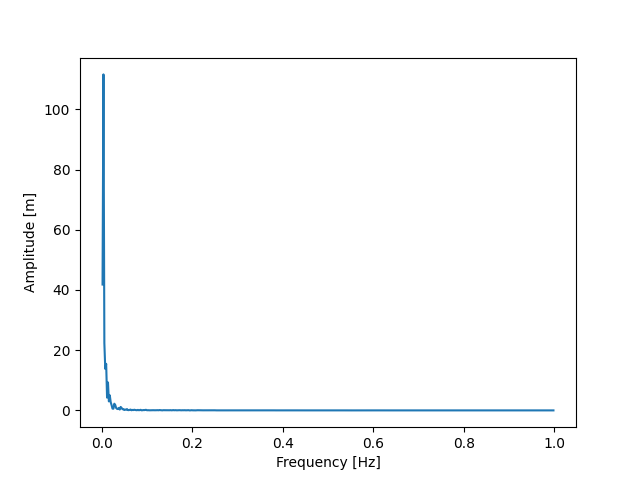

In [15]:
# Examine a smaller section to reduce computation 
ind_in_wave_band = freq_onesided < 1
freq_in_wave_band = freq_onesided[ind_in_wave_band]
z_fft_in_wave_band = z_fft_onesided[ind_in_wave_band]
#*Note since we want to find the optimal filter with this I dont want to use the spectra with componets already zeroed

# Plot the FFT in the wave band 
fig_waveband, ax = plt.subplots()
ax.plot(freq_in_wave_band, np.abs(z_fft_in_wave_band))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [m]')


In [16]:
def fitlerZFFT(position_fft, filter_array):
    # Filter the position fft by multiplying by the filter array
    position_fft_filt = position_fft * filter_array

    return position_fft_filt

def computeEnergySpectra(position_fft, sample_freq):
    # Compute Energy Spectra from filtered position fft - onesided
    num_points = position_fft.size * 2 # multiplied by two since this is a one sided spectrum and the input was double this number of points
    del_f = sample_freq / num_points
    E = np.abs(position_fft**2) / del_f

    return E

def optimalFilterDesign(filter_array, position_fft, sample_freq, E_awac):
    # Filter the position fft
    position_fft_filt = fitlerZFFT(position_fft, filter_array)

    # Compute the Energy Density from the filtered position fft
    E_micro = computeEnergySpectra(position_fft_filt, sample_freq)

    # Compute the Mean Square Error
    mse = (1/E_micro.size) * np.sum((E_micro - E_awac)**2)

    return mse
    
# Reinterpolate the AWAC spectra to be within the wave band 
E_awac_in_wave_band = np.interp(freq_in_wave_band, f_awac, E_awac)

# Define a basic filter of all ones to see what the optimal filter it gives out looks like
filter_guess = np.ones(freq_in_wave_band.size)

# Define the bounds of the optimization 
#*Note must be between zero and 1 since we are defining a filter and dont want to add extra energy to the measurements
# bnds = [(0, 1) for _ in filter_guess]

# Optimize the filter array by minimizing the mean square error 
res = optimize.minimize(optimalFilterDesign, x0=filter_guess, args=(z_fft_in_wave_band, sample_freq, E_awac_in_wave_band), tol=10, options={'maxiter':200, 'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: 0.025053
         Iterations: 196
         Function evaluations: 109500
         Gradient evaluations: 219
      fun: 0.025052964032794504
 hess_inv: array([[ 2.25989364e-04, -2.62997124e-05, -1.69768239e-05, ...,
        -1.08465786e-06, -6.69734317e-07, -3.42343365e-06],
       [-2.62997124e-05,  7.82805501e-06,  6.93524138e-06, ...,
         2.91555589e-07,  1.82842490e-07,  9.55919425e-07],
       [-1.69768239e-05,  6.93524138e-06,  2.06470487e-04, ...,
         3.69289732e-07,  2.31857207e-07,  1.08217461e-06],
       ...,
       [-1.08465786e-06,  2.91555589e-07,  3.69289732e-07, ...,
         1.00000001e+00,  7.03819456e-09,  3.65623564e-08],
       [-6.69734317e-07,  1.82842490e-07,  2.31857207e-07, ...,
         7.03819456e-09,  1.00000000e+00,  2.28476048e-08],
       [-3.42343365e-06,  9.55919425e-07,  1.08217461e-06, ...,
         3.65623564e-08,  2.28476048e-08,  1.00000012e+00]])
      jac: array([-1.2

Text(0, 0.5, 'Amplitude')

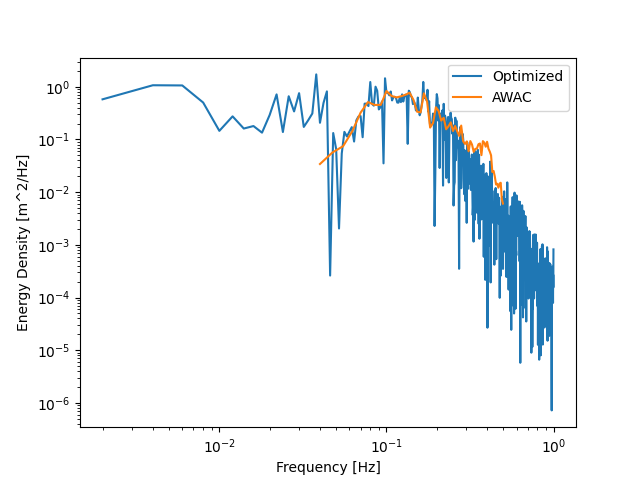

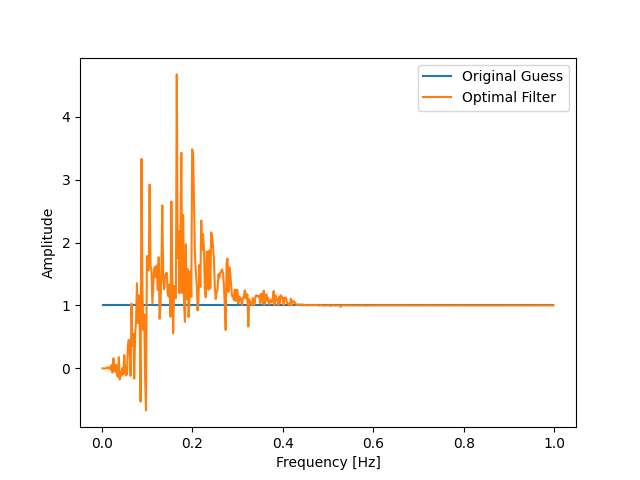

In [17]:
# Lets examine the Optimal Filter that it came up with
optimal_filter = res.x

# Compute the Spectra
z_fft_in_wave_band_filt = fitlerZFFT(z_fft_in_wave_band, optimal_filter)
E_optimized = computeEnergySpectra(z_fft_in_wave_band_filt, sample_freq)

# Plot the Optimized Spectra and the AWAC spectra
fig_optimal_spec, ax = plt.subplots()
ax.loglog(freq_in_wave_band, E_optimized, label='Optimized')
ax.loglog(f_awac, E_awac, label='AWAC')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')

# Plot the filter 
fig_filter, ax = plt.subplots()
ax.plot(freq_in_wave_band, filter_guess, label='Original Guess')
ax.plot(freq_in_wave_band, optimal_filter, label='Optimal Filter')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

Well I haven't been able to figure out how to use the bounds function to optimize between 0 and 1 for the filter but here we see the major features are the values less than 0.05 are effectively zero (<0.2) and then there is some weirdness from there up to 0.1 where the filter then passes back over the line for one. There is then some super elvation after that which is adding values to the sigal artifically and we should not use. Lets try making a gaussian function that has a similar curve to the one that shows up and see how well it can do. 

Text(0, 0.5, 'Amplitude')

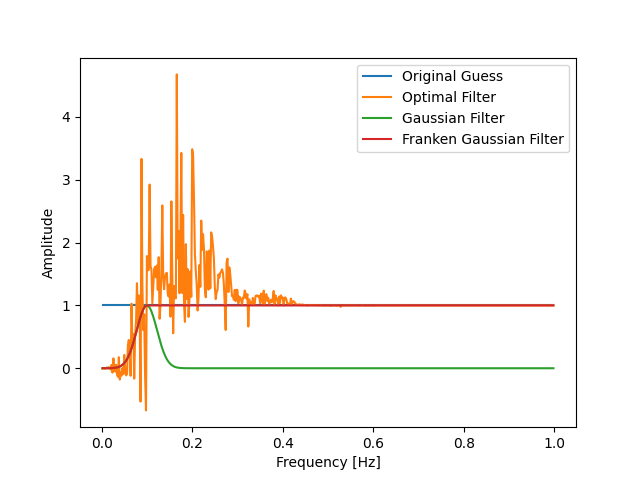

In [18]:
# Define a Gaussian filter
width = 0.0005
center = 0.1
gaussian_filter = (1/(np.sqrt(width * 2 * np.pi))) * np.exp(-0.5 * (freq_in_wave_band - center)**2 / width)
gaussian_filter_norm = gaussian_filter / np.max(gaussian_filter)

# Franken Gaussian where all values greater than center are one
franken_gaussian = gaussian_filter_norm.copy()
franken_gaussian[freq_in_wave_band > center] = 1

# Plot the filter compared to the optimal filter
fig_filter_test, ax = plt.subplots()
ax.plot(freq_in_wave_band, filter_guess, label='Original Guess')
ax.plot(freq_in_wave_band, optimal_filter, label='Optimal Filter')
ax.plot(freq_in_wave_band, gaussian_filter_norm, label='Gaussian Filter')
ax.plot(freq_in_wave_band, franken_gaussian, label='Franken Gaussian Filter')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

Well now we have made some filters and they are related to the optimzed filter - lets see how they do in comparison. Also I wonder if there is anyway to recorrelate the location and width of this filter with the actual dataset, Hmmm.

Text(0, 0.5, 'Energy Density [m^2/Hz]')

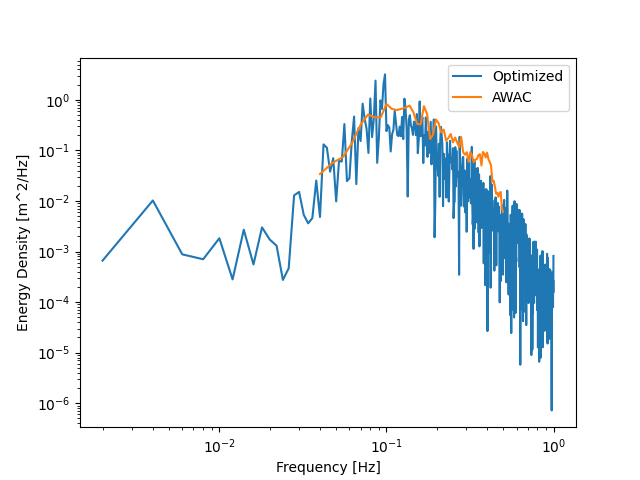

In [19]:
# Compute Spectrum with the Franken Gaussian
z_fft_in_wave_band_filt_fg = fitlerZFFT(z_fft_in_wave_band, franken_gaussian)
E_franken = computeEnergySpectra(z_fft_in_wave_band_filt_fg, sample_freq)

# Plot the Franken Spectra and the AWAC spectra
fig_optimal_spec, ax = plt.subplots()
ax.loglog(freq_in_wave_band, E_franken, label='Optimized')
ax.loglog(f_awac, E_awac, label='AWAC')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')

Well this looks very nice, the franken gaussian looks pretty good. Now we want to apply this filter to the position fft and then inverse FFT to see the time series. To start this we need to reconstruct the two sided FFT from the one sided integrated FFT.

This time series of elevation looks super reasonable! Now lets make this a bit more general by making a function that computes that position fft from the acceleration time series directly for an arbitrary number of points so that we can test this filter against a bunch of different time series.

From Collins et al. 2010 - The main result is data which is not tilt corrected, even in the absence of sustained heel, will give unrealistic statistics. In addition, the size and shape of rogue waves may be severely altered without the tilt correction.

So it sounds like we will need to do some correction - but what correction do we do? How will we know? I should email Pat to ask if they have the raw pressure data from the 4.5 m AWAC and see if we can reconstruct that phase resolved wave signal with the buoys. But the buoys are moving - we can try to shoal the pressure time series to see what it would look like at the cross shore location of the micro. We still dont know what to do about keeping the real or imaginary parts of the inverse FFT? 

These are the assumptions they make in Collins et al. 2010: 
    - Measurements should not be made where other environmental factors strongly affect the wave shape (e.g., in strong current gradients, reflections from platforms, sharply varying and/or shallow bathymetry)
    - It is preferable that sensors measure η directly
    - If a transfer function is necessary, results from sensors which invoke a small amplitude assumption (e.g., pressure sensors) may be invalid particularly in the cases of interest (i.e., waves with extreme heights and steepness)
    - It is necessary to develop quality control measures which will aid in understanding the strengths and weaknesses of the data  

We seem to violate most of these assumptions! What to do next? 

There is a lot going on now - lets make a good clean list of what functions there are and what they do. 

accel_z, sampling_freq --> computeZFFT(accel_z, sampling_freq) --> z_fft_onesided, freq_onesided 
    This goes from the raw acceleration signal in the z direction and the sampling frequecy to the one sided sea surface elevation fft. This one sided sea surface fft can now be either used to compute the energy spectrum or get the position time series

z_fft_onesided, filter_array --> fitlerZFFT(position_fft, filter_array) --> position_fft_filt
    This function takes in the z_fft_onesided that is computed from computeZFFT(accel_z, sampling_freq) and a filter array that we are designing and filters the z_fft to output a filtered fft. The output of this function can then be input into either computeEta() or computeEnergySpectra().



<h2>Switching gears - Looking at Optimal time domain filtering and time domain Integrating</h2>


Text(0, 0.5, 'Acceleration [m/s^2]')

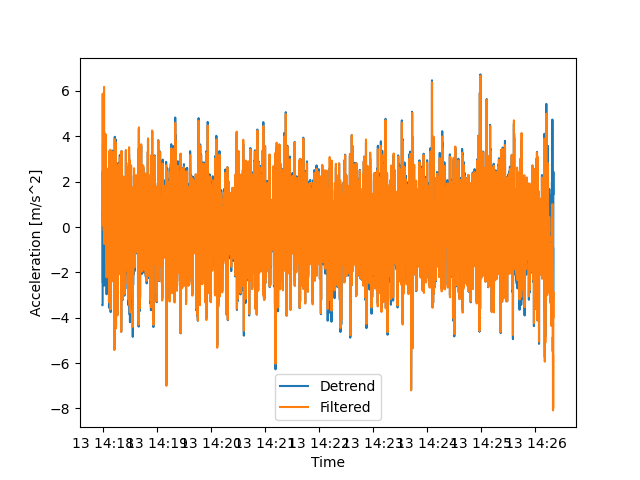

In [23]:
# Filtering in Time with a forward-backward linear digital filter 
low_freq_cutoff = 0.055
high_freq_cutoff = 1
# b, a = signal.butter(1, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=12)
b, a = signal.butter(1, low_freq_cutoff, btype='highpass', fs=12)
accel_z_filt = signal.filtfilt(b, a, signal.detrend(accel_z_demean))

# Plot the filtered and Original Signal
fig_filt, ax = plt.subplots()
ax.plot(time_datetime, accel_z_demean, label='Detrend')
ax.plot(time_datetime, accel_z_filt, label='Filtered')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2]')

Well this filter actually looks pretty 

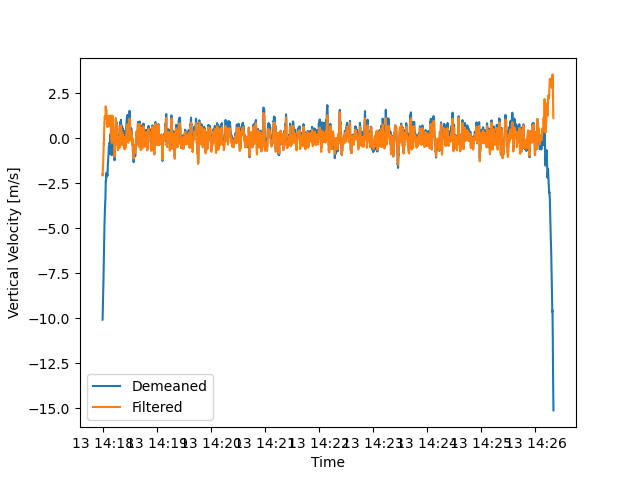

In [24]:
# Double integrate the filtered signal and compute the energy spectrum 
w = integrate.cumulative_trapezoid(accel_z_filt, dx=1/12, initial=0)
w_filt = signal.filtfilt(b, a, w)

# Plot the double integrated, filtered signal
fig_int, ax = plt.subplots()
ax.plot(time_datetime, w - np.mean(w), label='Demeaned')
ax.plot(time_datetime, w_filt, label='Filtered')
ax.set_xlabel('Time')
ax.set_ylabel('Vertical Velocity [m/s]')
ax.legend()

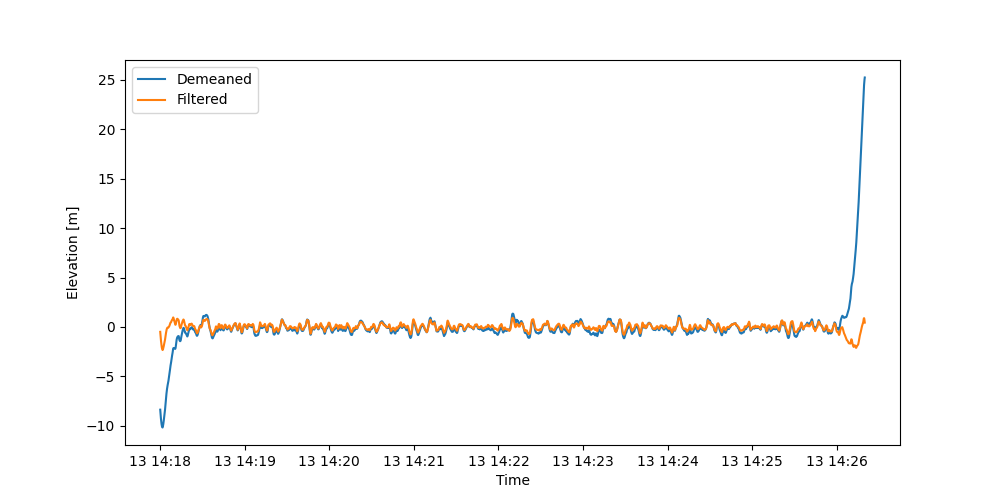

In [25]:
# Integrate the Velocity to get position
z = integrate.cumulative_trapezoid(w_filt, dx=1/12, initial=0)
z_filt = signal.filtfilt(b, a, z)

# Plot the double integrated, filtered signal
fig_z, ax = plt.subplots(figsize=(10,5))
ax.plot(time_datetime, z - np.mean(z), label='Demeaned')
ax.plot(time_datetime, z_filt, label='Filtered')
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')
ax.legend()

Well this actaully looks better than I would have guessed! It feels funny to filter at each integration step but that may not be that strange of a thing. We do need to remove the ends before making a spectrum since it seems that the filter led to some weird edge effects - maybe gibbs phenomena? 

(5100,)


/var/folders/yq/nm8v_c9d4_dbks_1kbmx542r0000gp/T/ipykernel_98062/142436087.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_z, ax = plt.subplots(figsize=(10,5))


Text(0, 0.5, 'Elevation [m]')

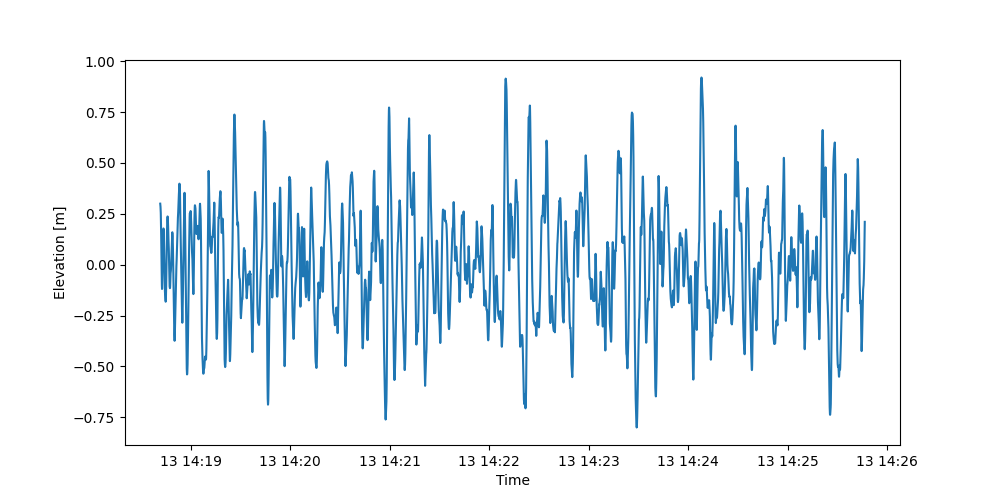

In [26]:
# Subset the position to cut off the ends
z_filt_subset = z_filt[500:-400]
print(z_filt_subset.shape)

# Plot the double integrated, filtered signal
fig_z, ax = plt.subplots(figsize=(10,5))
ax.plot(time_datetime[500:-400], z_filt_subset)
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')


This is a reasonable looking time series - lets try to just make a statistically significant Energy spectrum from this directly.

Window length to match AWAC resolution: 1600
Equivalent Degrees of Freedom: 4.25


Text(0, 0.5, 'Energy Density [m^2/Hz]')

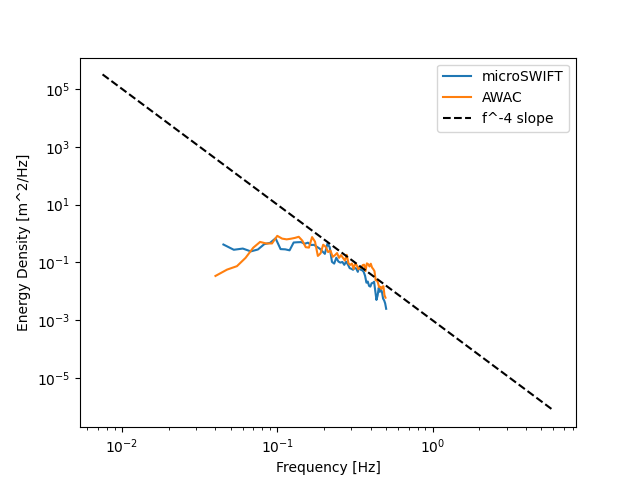

In [105]:
# Compute Energy Spectra from the time series
# Spectral Parameters: 512 points in window (2^9, 42 seconds ~ 7 waves per window with a peak period of 6 seconds)
# Number of windows = 11 ~ 22 degrees of freedom
# Overall length of signal is 5600 points (7.77 minutes)
# Compute Window length to use to match the AWAC spectrum 
nperseg_to_match_awac = int(microSWIFT_test.sampling_freq/0.0075)
print('Window length to match AWAC resolution: {}'.format(nperseg_to_match_awac))
nperseg = 1600
freq_micro, E_micro = signal.welch(z_filt_subset, fs=12, window='hann', nperseg=nperseg, noverlap=np.floor(nperseg*0.75))

# Compute the confidence intervals
edof = (8/3) * (z_filt_subset.size / nperseg/2) # From page 479 in Data Analysis methods in Physical Oceanography 
print('Equivalent Degrees of Freedom: {}'.format(edof))

# Plot the computed spectra compared to the AWAC spectra
fig_spec, ax = plt.subplots()
ax.loglog(freq_micro[5:69], E_micro[5:69], label='microSWIFT')
ax.loglog(f_awac, E_awac, label='AWAC')
ax.plot(freq_micro[1:], 0.001 * freq_micro[1:]**(-4), label='f^-4 slope', color='k', linestyle='dashed')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2/Hz]')

In [103]:
# Compare the spectra with a ratio between the microSWIFT and the AWAC
print(f_awac)
print(freq_micro[5:69])

[0.04   0.0475 0.055  0.0625 0.07   0.0775 0.085  0.0925 0.1    0.1075
 0.115  0.1225 0.13   0.1375 0.145  0.1525 0.16   0.1675 0.175  0.1825
 0.19   0.1975 0.205  0.2125 0.22   0.2275 0.235  0.2425 0.25   0.2575
 0.265  0.2725 0.28   0.2875 0.295  0.3025 0.31   0.3175 0.325  0.3325
 0.34   0.3475 0.355  0.3625 0.37   0.3775 0.385  0.3925 0.4    0.4075
 0.415  0.4225 0.43   0.4375 0.445  0.4525 0.46   0.4675 0.475  0.4825
 0.49   0.4975]
[0.0375 0.045  0.0525 0.06   0.0675 0.075  0.0825 0.09   0.0975 0.105
 0.1125 0.12   0.1275 0.135  0.1425 0.15   0.1575 0.165  0.1725 0.18
 0.1875 0.195  0.2025 0.21   0.2175 0.225  0.2325 0.24   0.2475 0.255
 0.2625 0.27   0.2775 0.285  0.2925 0.3    0.3075 0.315  0.3225 0.33
 0.3375 0.345  0.3525 0.36   0.3675 0.375  0.3825 0.39   0.3975 0.405
 0.4125 0.42   0.4275 0.435  0.4425 0.45   0.4575 0.465  0.4725 0.48
 0.4875 0.495  0.5025 0.51  ]


Text(0, 0.5, 'Acceleration [m/s^2]')

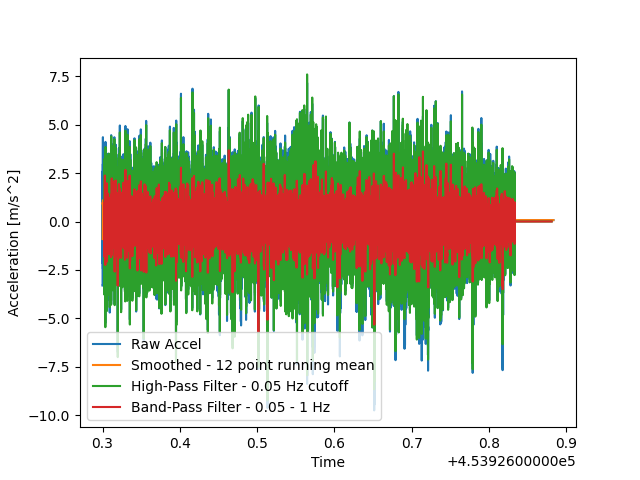

In [29]:
# 1 Hz smoothing of the acceleration
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)# 1 Hz smoothing function 

# Define the acceleration we are using to compare
accel = microSWIFT_test.az_body - np.mean(microSWIFT_test.az_body)
time = microSWIFT_test.time

# Smooth the Acceleration data
points_to_smooth = 12
accel_smoothed = running_mean(accel, points_to_smooth)
time_smoothed = running_mean(time, points_to_smooth)

# Zero pad the edges to reduce edge effects
pad_size = 500
accel_padded = np.zeros(accel.size + pad_size*2)
accel_padded[pad_size:-pad_size] = accel

# High Pass Filter
low_freq_cutoff = 0.05
b_highpass, a_highpass = signal.butter(1, low_freq_cutoff, btype='highpass', fs=12)
accel_highpass = signal.filtfilt(b_highpass, a_highpass, accel_padded)

# Band Pass Filter
high_freq_cutoff = 1
b_bandpass, a_bandpass = signal.butter(1, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=12)
accel_bandpass = signal.filtfilt(b_bandpass, a_bandpass, accel_padded)

# Remove edge effects from high and band pass filter
edge_removed = 100
time_filt = time[edge_removed : -edge_removed]
accel_highpass_noedge = accel_highpass[pad_size + edge_removed : -(pad_size + edge_removed)]
accel_bandpass_noedge = accel_bandpass[pad_size + edge_removed : -(pad_size + edge_removed)]

# Plot the smoothed and raw acceleration
fig_smooth, ax = plt.subplots()
ax.plot(time, accel, label='Raw Accel')
ax.plot(time_smoothed, accel_smoothed, label='Smoothed - 12 point running mean')
ax.plot(time_filt, accel_highpass_noedge, label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, accel_bandpass_noedge, label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration [m/s^2]')


Text(0, 0.5, 'Vertical Velocity [m/s]')

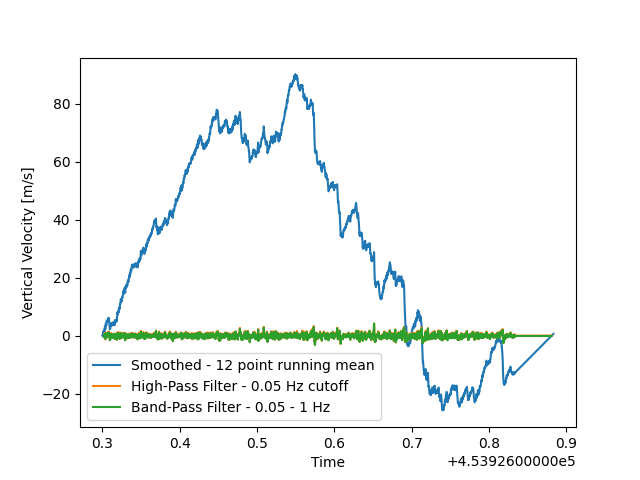

In [30]:
# Integrate each each of the signals to see the velocity
fs = microSWIFT_test.sampling_freq
# Smoothed
w_smoothed = integrate.cumulative_trapezoid(accel_smoothed, dx=1/fs, initial=0)

# High-Pass Filtered
w_highpass = integrate.cumulative_trapezoid(accel_highpass_noedge, dx=1/fs, initial=0)

# Band-Pass Filtered
w_bandpass = integrate.cumulative_trapezoid(accel_bandpass_noedge, dx=1/fs, initial=0)

# Plot each vertical velocity signal
fig_vel, ax = plt.subplots()
ax.plot(time_smoothed, w_smoothed, label='Smoothed - 12 point running mean')
ax.plot(time_filt, w_highpass, label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, w_bandpass, label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Vertical Velocity [m/s]')


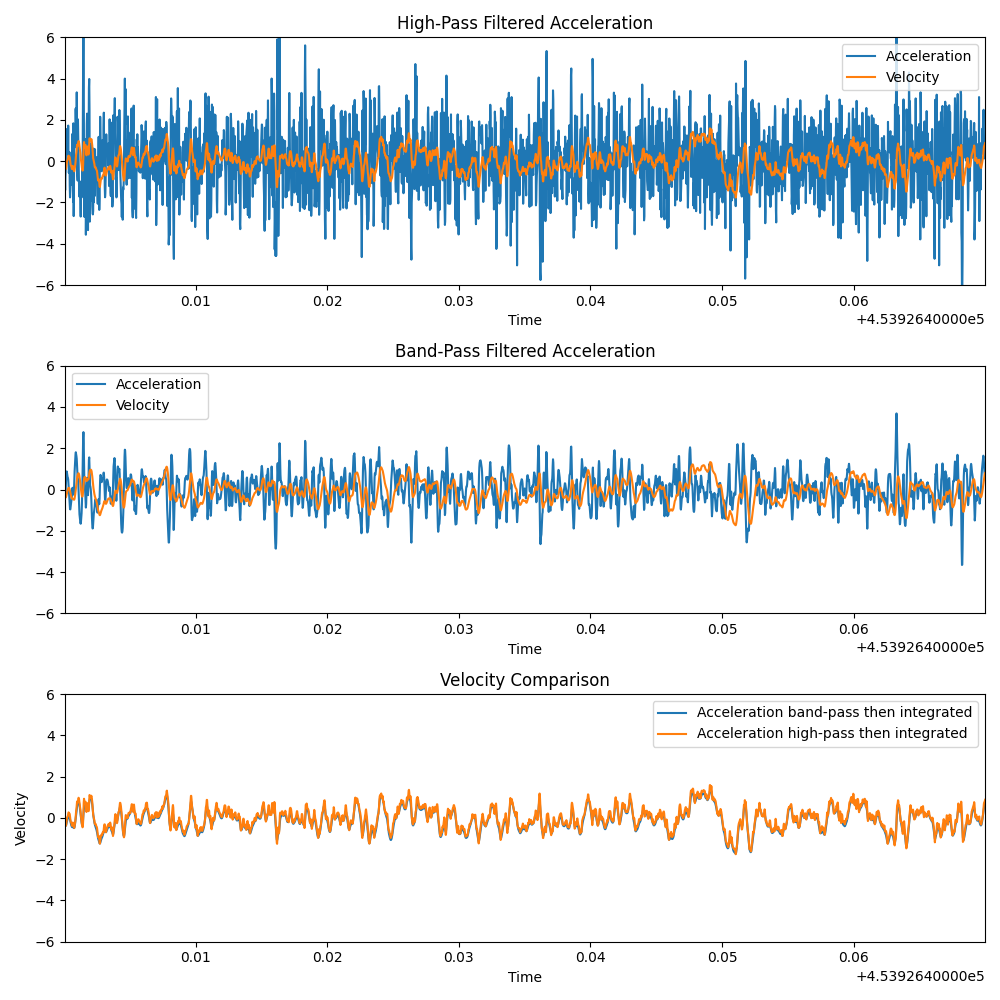

In [31]:
# Compare the high-pass and band-pass acceleration and velocity 
fig_aw_comp, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,10))
ax1.plot(time_filt, accel_highpass_noedge, label='Acceleration')
ax1.plot(time_filt, w_highpass, label='Velocity')
ax1.set_title('High-Pass Filtered Acceleration')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_xlim(453926.40004, 453926.46999)
ax1.set_ylim(-6, 6)

ax2.plot(time_filt, accel_bandpass_noedge, label='Acceleration')
ax2.plot(time_filt, w_bandpass, label='Velocity')
ax2.set_title('Band-Pass Filtered Acceleration')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_xlim(453926.40004, 453926.46999)
ax2.set_ylim(-6, 6)

ax3.plot(time_filt, w_bandpass, label='Acceleration band-pass then integrated')
ax3.plot(time_filt, w_highpass, label='Acceleration high-pass then integrated')
ax3.set_title('Velocity Comparison')
ax3.legend()
ax3.set_xlabel('Time')
ax3.set_ylabel('Velocity')
ax3.set_xlim(453926.40004, 453926.46999)
ax3.set_ylim(-6, 6)

plt.tight_layout()

Text(0, 0.5, 'Sea Surface Elevation [m/s]')

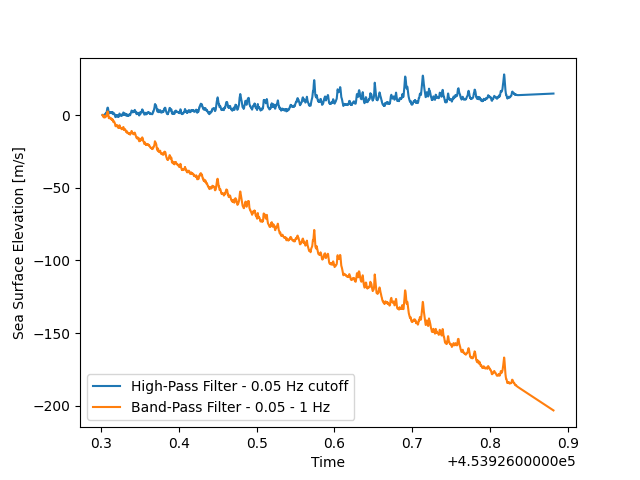

In [32]:
# Integrate the velocites to get position 
# High-Pass Filtered
eta_highpass = integrate.cumulative_trapezoid(w_highpass, dx=1/fs, initial=0)

# Band-Pass Filtered
eta_bandpass = integrate.cumulative_trapezoid(w_bandpass, dx=1/fs, initial=0)

# Plot each eta signal
fig_eta, ax = plt.subplots()
ax.plot(time_filt, eta_highpass, label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, eta_bandpass, label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m/s]')


Here we see that a linear trend has been introduced in the sea surface elevation signals from a mean value in the velocities, lets investigate what the mean values are for each of the velocity signals

In [33]:
# Compute a Mean Value for the high-pass and bad-pass filters
w_highpass_mean = np.nanmean(w_highpass)
w_bandpass_mean = np.nanmean(w_bandpass)

print('Mean Value for w from highpass filtered acceleration: {}'.format(w_highpass_mean))
print('Mean Value for w from bandpass filtered acceleration: {}'.format(w_bandpass_mean))

Mean Value for w from highpass filtered acceleration: 0.007081667979294899
Mean Value for w from bandpass filtered acceleration: -0.09747149498890217


Text(0, 0.5, 'Sea Surface Elevation [m]')

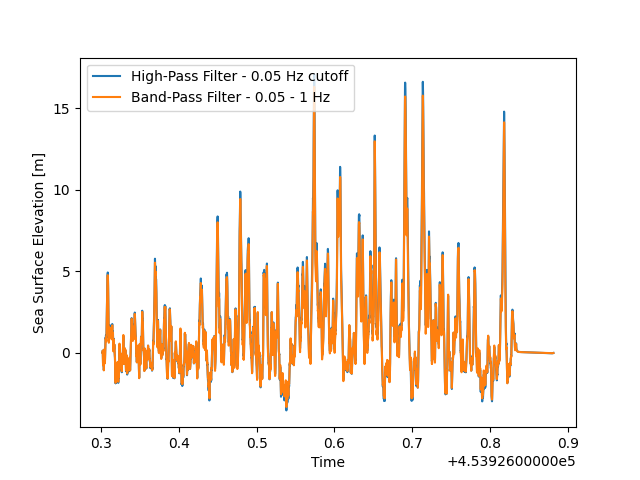

In [34]:
# Remove the mean from the velocites and integrate again
# # High-Pass Filtered
eta_highpass_nomean = integrate.cumulative_trapezoid(w_highpass - w_highpass_mean, dx=1/fs, initial=0)

# Band-Pass Filtered
eta_bandpass_nomean = integrate.cumulative_trapezoid(w_bandpass - w_bandpass_mean, dx=1/fs, initial=0)

# Plot each eta signal
fig_eta, ax = plt.subplots()
ax.plot(time_filt, eta_highpass_nomean, label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, eta_bandpass_nomean, label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')

Well this is not correct - lets try to integrate then remove the trend. This looks so different than what I would expect from integrating the velocity signals above

Text(0, 0.5, 'Sea Surface Elevation [m/s]')

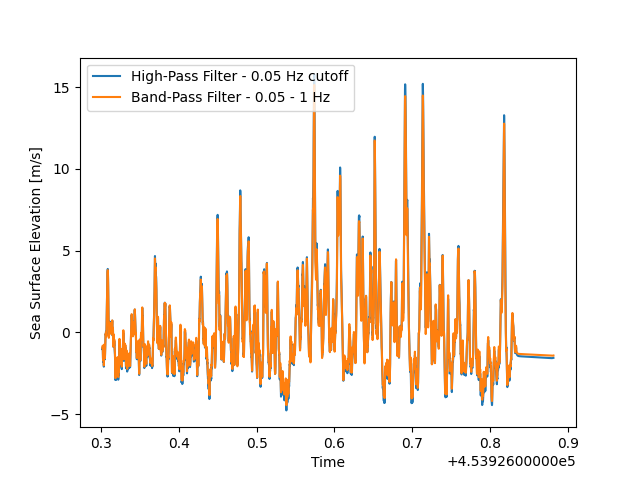

In [35]:
# Plot each eta signal
fig_eta_detrend, ax = plt.subplots()
ax.plot(time_filt, signal.detrend(eta_highpass), label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, signal.detrend(eta_bandpass), label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m/s]')

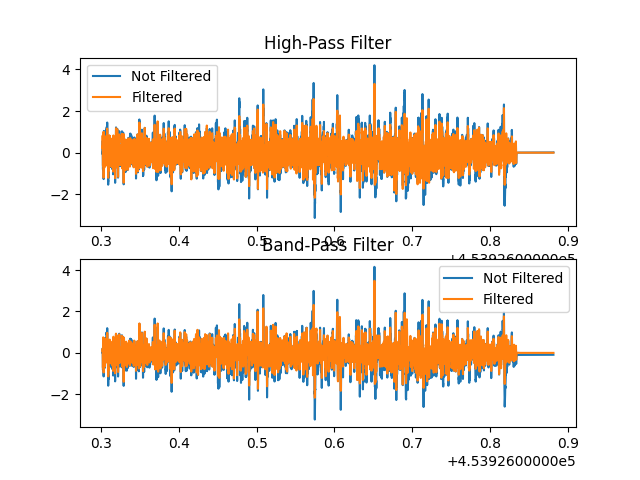

In [36]:
# Lets try to filter the velocities again then integrate
# High Pass Filter
low_freq_cutoff = 0.05
b_highpass, a_highpass = signal.butter(1, low_freq_cutoff, btype='highpass', fs=12)
w_highpass_highpass = signal.filtfilt(b_highpass, a_highpass, w_highpass)

# Band Pass Filter
high_freq_cutoff = 1
b_bandpass, a_bandpass = signal.butter(1, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=12)
w_bandpass_bandpass = signal.filtfilt(b_bandpass, a_bandpass, w_bandpass)

# Plot and compare the filtered velocity signals
fig_eta_filt, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(time_filt, w_highpass, label='Not Filtered')
ax1.plot(time_filt, w_highpass_highpass, label='Filtered')
ax1.set_title('High-Pass Filter')
ax1.legend()

ax2.plot(time_filt, w_bandpass, label='Not Filtered')
ax2.plot(time_filt, w_bandpass_bandpass, label='Filtered')
ax2.set_title('Band-Pass Filter')
ax2.legend()

Text(0.5, 1.0, 'Band-Pass Filter - Components Removed')

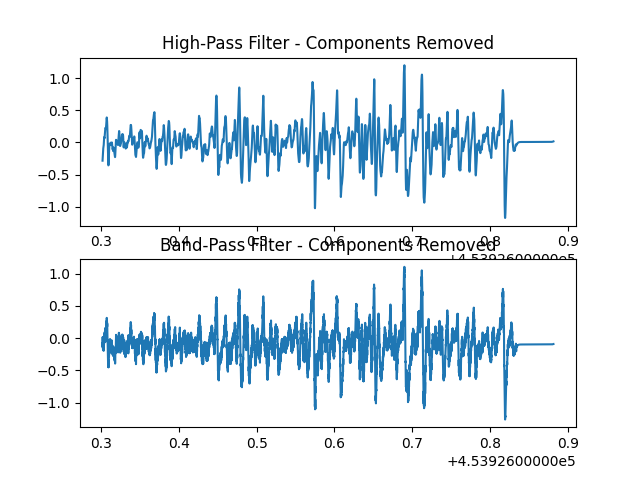

In [37]:
# Lets look at the difference between these signals to see the components that were removed
fig_vel_compon, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(time_filt, w_highpass - w_highpass_highpass)
ax1.set_title('High-Pass Filter - Components Removed')

ax2.plot(time_filt, w_bandpass - w_bandpass_bandpass)
ax2.set_title('Band-Pass Filter - Components Removed')


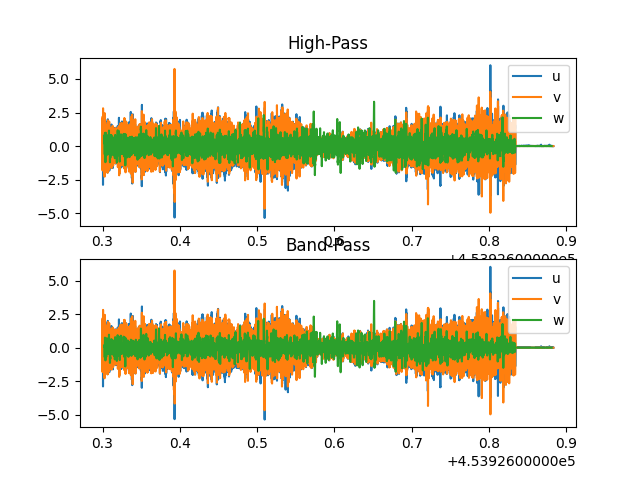

In [38]:
# Compare phasing of gps velocity and vertical velocity for high-pass and band-pass
fig_gpsvel_comp, (ax1, ax2) = plt.subplots(nrows=2)
# High-pass
ax1.plot(microSWIFT_test.time, microSWIFT_test.u, label='u')
ax1.plot(microSWIFT_test.time, microSWIFT_test.v, label='v')
ax1.plot(time_filt, w_highpass_highpass, label='w')
ax1.set_title('High-Pass')
ax1.legend()

# Band-pass
ax2.plot(microSWIFT_test.time, microSWIFT_test.u, label='u')
ax2.plot(microSWIFT_test.time, microSWIFT_test.v, label='v')
ax2.plot(time_filt, w_bandpass_bandpass, label='w')
ax2.set_title('Band-Pass')
ax2.legend()


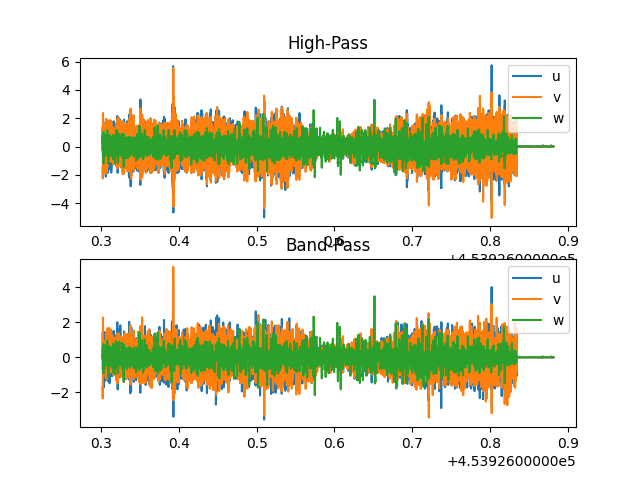

In [39]:
# Lets see what happens if you filter the GPS velocities
# High-pass
u_highpass = signal.filtfilt(b_highpass, a_highpass, microSWIFT_test.u)[100:-100]
v_highpass = signal.filtfilt(b_highpass, a_highpass, microSWIFT_test.v)[100:-100]

# Band-pass
u_bandpass = signal.filtfilt(b_bandpass, a_bandpass, microSWIFT_test.u)[100:-100]
v_bandpass = signal.filtfilt(b_bandpass, a_bandpass, microSWIFT_test.v)[100:-100]

fig_gpsvel_filt, (ax1, ax2) = plt.subplots(nrows=2)
# High-pass
ax1.plot(time_filt, u_highpass, label='u')
ax1.plot(time_filt, v_highpass, label='v')
ax1.plot(time_filt, w_highpass_highpass, label='w')
ax1.set_title('High-Pass')
ax1.legend()

# Band-pass
ax2.plot(time_filt, u_bandpass, label='u')
ax2.plot(time_filt, v_bandpass, label='v')
ax2.plot(time_filt, w_bandpass_bandpass, label='w')
ax2.set_title('Band-Pass')
ax2.legend()

Text(0.5, 1.0, 'Band-pass')

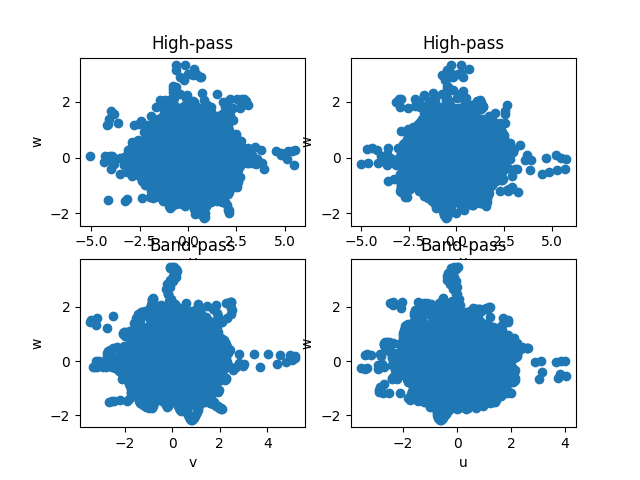

In [40]:
# PLot the orbits of the waves
fig_orbit, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
ax1.scatter(v_highpass, w_highpass_highpass)
ax1.set_xlabel('v')
ax1.set_ylabel('w')
ax1.set_title('High-pass')

ax2.scatter(u_highpass, w_highpass_highpass)
ax2.set_xlabel('u')
ax2.set_ylabel('w')
ax2.set_title('High-pass')

ax3.scatter(v_bandpass, w_bandpass_bandpass)
ax3.set_xlabel('v')
ax3.set_ylabel('w')
ax3.set_title('Band-pass')

ax4.scatter(u_bandpass, w_bandpass_bandpass)
ax4.set_xlabel('u')
ax4.set_ylabel('w')
ax4.set_title('Band-pass')


In [41]:
# Now lets animate these orbits 



Text(0, 0.5, 'Sea Surface Elevation [m]')

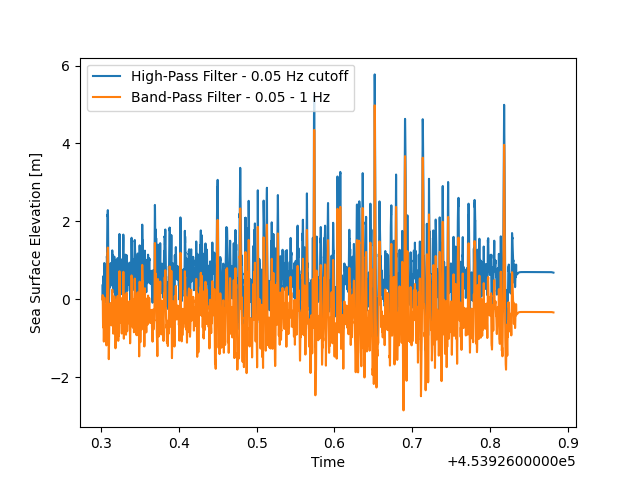

In [42]:
# Integrate the filtered vertical velocities to get eta
# High-Pass Filtered
eta_highpass = integrate.cumulative_trapezoid(w_highpass_highpass, dx=1/fs, initial=0)

# Band-Pass Filtered
eta_bandpass = integrate.cumulative_trapezoid(w_bandpass_bandpass, dx=1/fs, initial=0)

# Plot each eta signal
fig_eta, ax = plt.subplots()
ax.plot(time_filt, eta_highpass, label='High-Pass Filter - 0.05 Hz cutoff')
ax.plot(time_filt, eta_bandpass, label='Band-Pass Filter - 0.05 - 1 Hz ')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')


In [43]:
# Filter each 

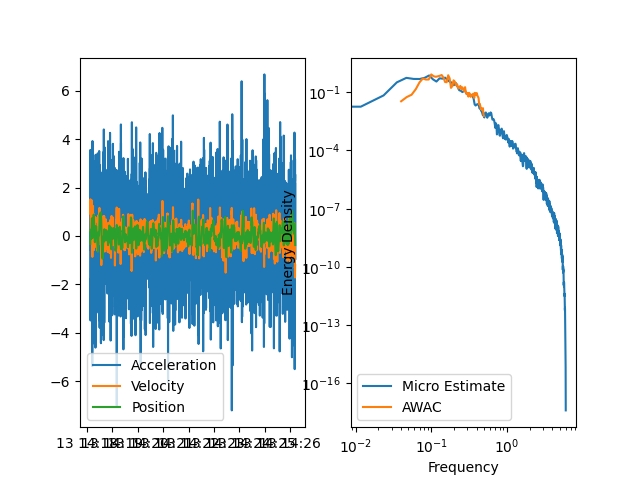

In [44]:
# Function to filter and integrate the time series
low_freq_cutoff = 0.05
high_freq_cutoff = 1
# b, a = signal.butter(1, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=12)
b, a = signal.butter(1, low_freq_cutoff, btype='highpass', fs=12)

def computeEta(t, accel_z, fs, a, b):
    # Zero pad the edges to reduce edge effects
    pad_size = 500
    a_z_padded = np.zeros(accel_z.size + pad_size*2)
    a_z_padded[pad_size:-pad_size] = accel_z

    # Filter and integrate to velocity and position
    a_z = signal.filtfilt(b, a, a_z_padded)
    w_nofilt = integrate.cumulative_trapezoid(a_z, dx=1/fs, initial=0)
    w = signal.filtfilt(b, a, w_nofilt)
    z_nofilt = integrate.cumulative_trapezoid(w, dx=1/fs, initial=0)
    z = signal.filtfilt(b, a, z_nofilt)

    # Remove the edges of the time series due to the edge effects of filtering
    edge_removed = 100
    t = t[edge_removed : -edge_removed]
    a_z = a_z[pad_size + edge_removed : -(pad_size + edge_removed)]
    w = w[pad_size + edge_removed : -(pad_size + edge_removed)]
    z = z[pad_size + edge_removed : -(pad_size + edge_removed)]

    return t, a_z, w, z

def computeSpectra(z, fs):
    # Compute Energy Spectra from the time series
    # Spectral Parameters: 512 points in window (2^9, 42 seconds ~ 7 waves per window with a peak period of 6 seconds)
    # Number of windows = 11 ~ 22 degrees of freedom
    # Overall length of signal is 5600 points (7.77 minutes)
    # edof is 14.58
    if z.size > 1024:
        nperseg = 1024
    elif z.size > 256: 
        nperseg = 256
    else:
        nperseg = z.size

    f, E = signal.welch(z, fs=fs, window='hann', nperseg=nperseg, noverlap=np.floor(nperseg*0.75))

    return f, E

# Compute Correct the acceleration to get kinematic time series
t, a_z, w, z = computeEta(time_datetime, accel_z, sample_freq, a, b)
f, E = computeSpectra(z, sample_freq)

# Plot the acceleation, velocity and position 
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(t, a_z, label='Acceleration')
ax1.plot(t, w, label='Velocity')
ax1.plot(t, z, label='Position')
ax1.legend()

ax2.loglog(f, E, label='Micro Estimate')
ax2.loglog(f_awac, E_awac, label='AWAC')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Energy Density')
ax2.legend()

Lets go back to the original test case and apply this filtering and integration over the entire signal then split it into section based on the bathymetry


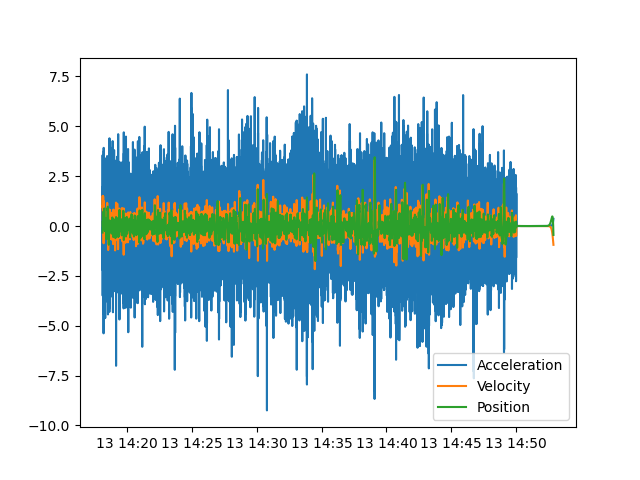

In [45]:
# Lets filter the entire signal for the test case microSWIFT
low_freq_cutoff = 0.05
b, a = signal.butter(1, low_freq_cutoff, btype='highpass', fs=12)
t_total, a_z_total, w_total, z_total = computeEta(microSWIFT_test.time_datetime, microSWIFT_test.az_body, microSWIFT_test.sampling_freq, a, b)

# Plot the Filtered and integrated signals
fig, ax = plt.subplots()
ax.plot(t_total, a_z_total, label='Acceleration')
ax.plot(t_total, w_total, label='Velocity')
ax.plot(t_total, z_total, label='Position')
ax.legend()


Well lets now look through every mission and find any time that a buoy was between 3.5-5.5 meters depth and if the record is at least 6000 points. We will then apply the same method as above and try to tune a butterworth filter to the these characteristics.

Text(0, 0.5, 'Elevation [m]')

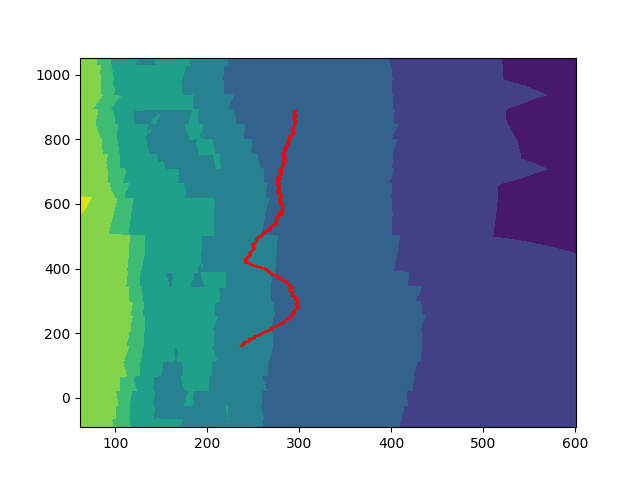

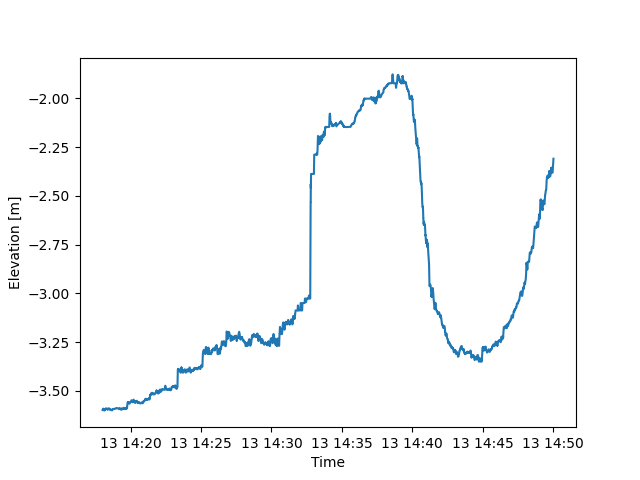

In [46]:
# Interpolate the bathymetry survey to get the bathymetry along the track 
test_bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_elevationTransects_survey_20211016.nc')
# NOTE: the survey on 10/13 did not go far enough south where this microSWIFT was so we are using the 10/16 survey

# Grid the survey data
spatial_res = 1
x_grid_vec = np.arange(np.min(test_bathy_data['xFRF'][:]), np.max(test_bathy_data['xFRF'][:]), spatial_res)
y_grid_vec = np.arange(np.min(test_bathy_data['yFRF'][:]), np.max(test_bathy_data['yFRF'][:]), spatial_res)
xi,yi = np.meshgrid(x_grid_vec, y_grid_vec)
elevation_grid = interpolate.griddata((test_bathy_data['xFRF'][:], test_bathy_data['yFRF'][:]), test_bathy_data['elevation'][:] , (xi, yi), method='nearest')

# Plot the gridded bathymetry survey
fig_bathy, ax = plt.subplots()
ax.contourf(xi, yi, elevation_grid) 
ax.plot(microSWIFT_test.x, microSWIFT_test.y, color='r')

# # Interpolate the Bathymetry grid along the microSWIFT track
test_points = 10
bathy_f = interpolate.interp2d(x_grid_vec, y_grid_vec, elevation_grid)
bathy_along_track = []
for n in np.arange(microSWIFT_test.x.size):
    bathy_along_track.append(np.squeeze(bathy_f(microSWIFT_test.x[n], microSWIFT_test.y[n])).item())

# Plot the bathy along the track
fig_bathy_track, ax = plt.subplots()
ax.plot(microSWIFT_test.time_datetime, bathy_along_track)
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')


Now lets split this bathymetry into sections and process it into elevation time series and spectra to get the significant wave height and then compute gamma

Text(0, 0.5, 'Elevation [m]')

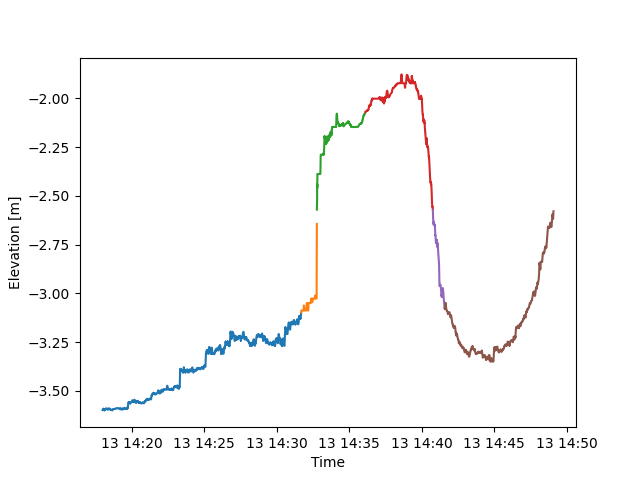

In [83]:
# Split the data into sections based on how much the bathymetry is changing
section_starts = []
section_ends = []
depth_change = 0.5
base_elevation = bathy_along_track[0]
section_start = 0
for n in np.arange(microSWIFT_test.x.size):
    if np.isnan(bathy_along_track[n]) == True:
        continue
    if bathy_along_track[n] < (base_elevation + depth_change) and bathy_along_track[n] > (base_elevation - depth_change):
        section_end = n
    else: 
        section_starts.append(section_start)
        section_ends.append(section_end)
        section_start = n
        base_elevation = bathy_along_track[n]

# Plot the sections of bathymety
fig_section, ax = plt.subplots()
for n in np.arange(len(section_starts)):
    ax.plot(microSWIFT_test.time_datetime[section_starts[n]:section_ends[n]], bathy_along_track[section_starts[n]:section_ends[n]])
ax.set_xlabel('Time')
ax.set_ylabel('Elevation [m]')


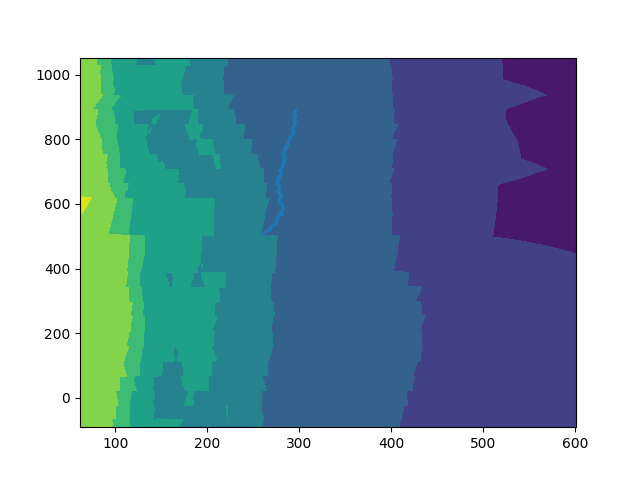

In [81]:
# Plot the sections in space 
fig_spatial_sections, ax = plt.subplots()
ax.contourf(xi, yi, elevation_grid) 
for n in np.arange(len(section_starts)):
    ax.plot(microSWIFT_test.x[section_starts[n]:section_ends[n]], microSWIFT_test.y[section_starts[n]:section_ends[n]])


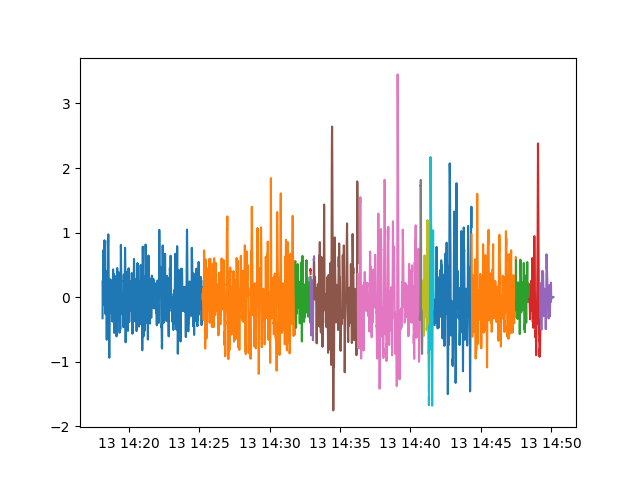

In [70]:
# Plot the sections of the position array
fig_section_pos, ax = plt.subplots()
for n in np.arange(len(section_starts)):
    ax.plot(t_total[section_starts[n]:section_ends[n]], z_total[section_starts[n]:section_ends[n]])

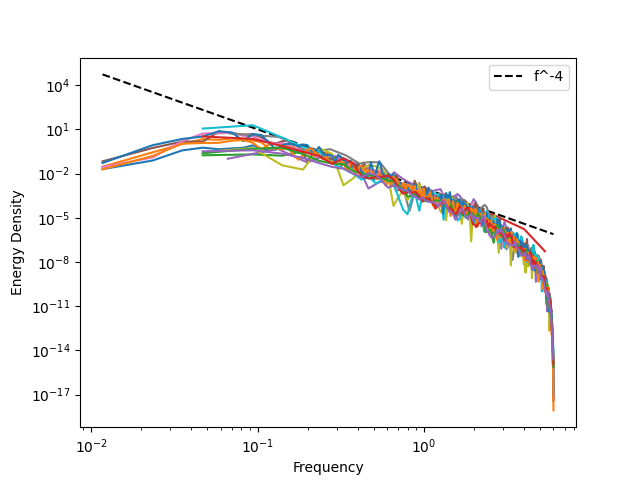

In [72]:
# Make a spectrum from each section of sea surface elevation
num_sections = len(section_starts)
freqs = []
E_spec = []
sample_freq = microSWIFT_test.sampling_freq
for n in np.arange(num_sections):
    f, E = computeSpectra(z_total[section_starts[n]:section_ends[n]], sample_freq)
    freqs.append(f)
    E_spec.append(E)

# Plot each Energy Spectrum
fig_specs, ax = plt.subplots()
ax.loglog(freqs[0], 0.001*freqs[0]**(-4), linestyle='dashed', color='k', label='f^-4')
ax.set_xlabel('Frequency')
ax.set_ylabel('Energy Density')
ax.legend()
for n in np.arange(num_sections):
    ax.loglog(freqs[n][1:], E_spec[n][1:])

Text(0, 0.5, 'Significant Wave Height')

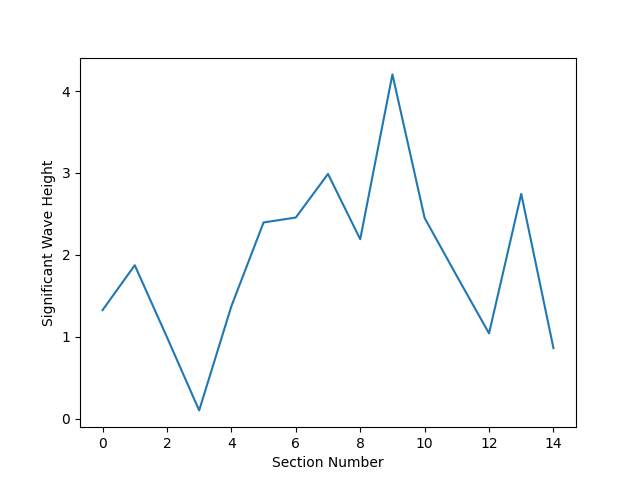

In [73]:
# Compute the significant wave height from each spectrum
section_Hs = []
for n in np.arange(num_sections):
    Hs = 4 * np.std(z_total[section_starts[n]:section_ends[n]])
    section_Hs.append(Hs)

# Plot the significant wave heights
fig, ax = plt.subplots()
ax.plot(section_Hs)
ax.set_xlabel('Section Number')
ax.set_ylabel('Significant Wave Height')

Text(0, 0.5, 'Gamma')

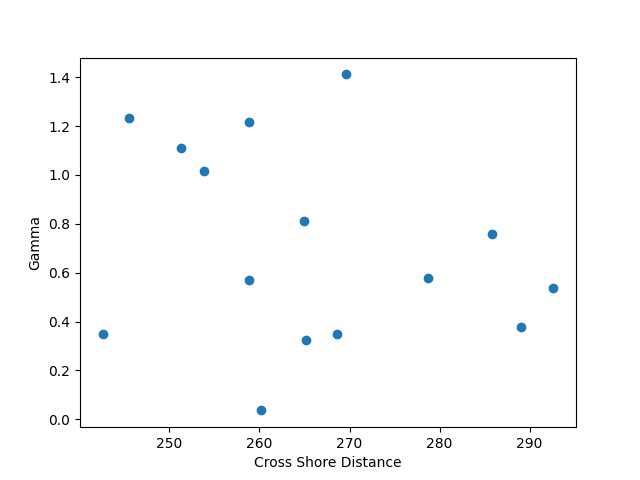

In [74]:
# Compute the average depth of each section and the average location
x_section = []
y_section = []
depth_section = []
for n in np.arange(num_sections):
    x_section.append(np.nanmean(microSWIFT_test.x[section_starts[n]:section_ends[n]]))
    y_section.append(np.nanmean(microSWIFT_test.y[section_starts[n]:section_ends[n]]))
    depth_section.append(np.nanmean(bathy_along_track[section_starts[n]:section_ends[n]]))

# Compute Gamma
gamma = [abs(Hs / d) for Hs, d in zip(section_Hs, depth_section)]

# Plot Gamma as a function of cross shore distance
fig_gamma, ax = plt.subplots()
ax.scatter(x_section, gamma)
ax.set_xlabel('Cross Shore Distance')
ax.set_ylabel('Gamma')
